In [6]:
import os, sys, glob, shutil, json
import torch as t
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, MultiStepLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch 
import torch.nn.functional as F
import json
from torchvision.models.mobilenet import MobileNetV2
from torchvision.models.resnet import resnet50, resnet34
from torchsummary import summary

%matplotlib inline

In [8]:
#查看数据
def data_summary():
    train_list = glob.glob('./data/mchar_train/*.png')
    test_list = glob.glob('./data/mchar_test_a/*.png')
    val_list = glob.glob('./data/mchar_val/*.png')
    print('train image counts: %d'%len(train_list))
    print('val image counts: %d'%len(val_list))
    print('test image counts: %d'%len(test_list))

data_summary()

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [16]:
train_path = glob.glob('./data/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('./data/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]
print(len(train_path), len(train_label))

30000 30000


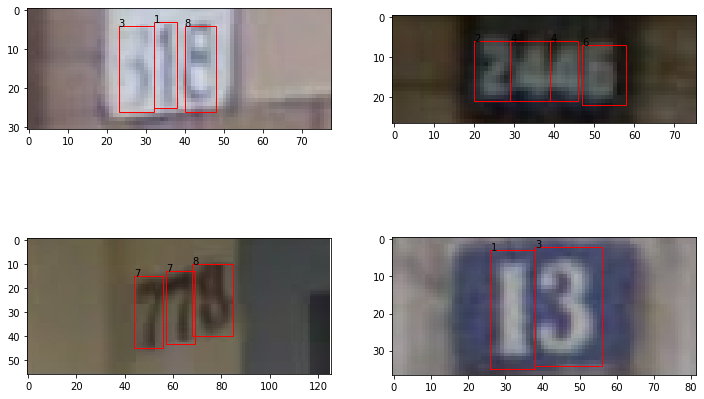

In [26]:
def plot_samples():
    imgs = glob.glob('./data/mchar_train/*.png')
    fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)
    marks = json.load(open('./data/mchar_train.json'))
                      
    for i in range(4):
        img_name = os.path.split(imgs[i])[-1]
        mark = marks[img_name]


        img = Image.open(imgs[i])
        img = np.array(img)

        bboxes = np.array(
            [mark['left'],
            mark['top'],
            mark['width'],
            mark['height']]
        )
        ax[i//2, i%2].imshow(img)
        for j in range(len(mark['label'])):
            rect = patch.Rectangle(bboxes[:, j][:2], bboxes[:, j][2], bboxes[:, j][3], facecolor='none', edgecolor='r')
            ax[i//2, i%2].text(bboxes[:, j][0], bboxes[:, j][1], mark['label'][j])
            ax[i//2, i%2].add_patch(rect)
    plt.show()

plot_samples()

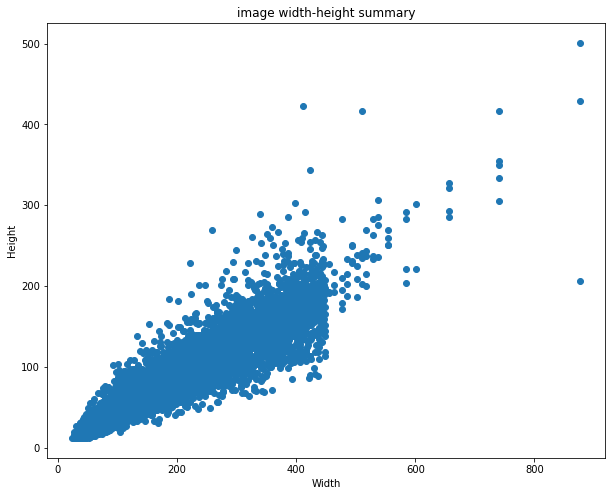

In [41]:
def img_size_summary():
    sizes = []

    for img in train_path:
        img = Image.open(img)

        sizes.append(img.size)

    sizes = np.array(sizes)

    plt.figure(figsize=(10, 8))
    plt.scatter(sizes[:, 0], sizes[:, 1])
    plt.xlabel('Width')
    plt.ylabel('Height')

    plt.title('image width-height summary')
    plt.show()
    return sizes

sizes = img_size_summary()

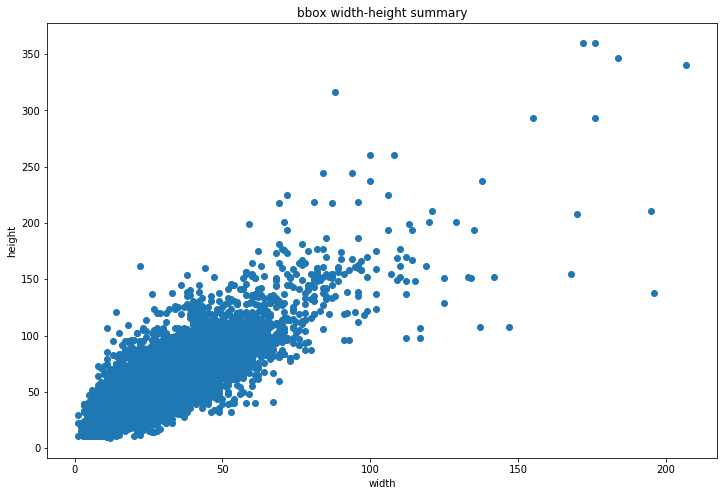

In [44]:
def bbox_summary():
    marks = train_json
    bboxes = []

    for img, mark in marks.items():
        for i in range(len(mark['label'])):
            bboxes.append([mark['left'][i], mark['top'][i], mark['width'][i], mark['height'][i]])

    bboxes = np.array(bboxes)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(bboxes[:, 2], bboxes[:, 3])
    ax.set_title('bbox width-height summary')
    ax.set_xlabel('width')
    ax.set_ylabel('height')
    plt.show()

bbox_summary()

In [46]:
def label_summary():
    marks = train_json

    dicts = {}
    for img, mark in marks.items():
        if len(mark['label']) not in dicts:
            dicts[len(mark['label'])] = 0
        dicts[len(mark['label'])] += 1


    dicts = sorted(dicts.items(), key=lambda x: x[0])
    for k, v in dicts:
        print('%d个数字的图片数目: %d'%(k, v))

label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1
